### Transfer Learning

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds 

from tensorflow.keras.applications.resnet50 import ResNet50 
from matplotlib import pyplot as plt 

print("Tensorflow version " + tf.__version__)


Tensorflow version 2.2.0


In [2]:
BATCH_SIZE = 32
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [3]:
plt.rc("image", cmap="gray")
plt.rc("grid", linewidth=0)
plt.rc("xtick", top=False, bottom=False, labelsize="large")
plt.rc("ytick", left=False, right=False, labelsize="large")
plt.rc("axes", facecolor="F8F8F8", titlesize="large", edgecolor="white")
plt.rc("text", color="a8151a")
plt.rc("figure", facecolor="F0F0F0")

MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__),"mpl-data/fonts/ttf")

def display_images(digits, predictions, labels, title):
    n = 10
    
    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))
    n_labels = labels[indexes]

    fig = plt.figure(figsize=(20,4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        ax = fig.add_subplot(1,10,i+1)
        class_index = n_predictions[i]

        plt.xlabel(classes[class_index])
        plt.xticks([])
        plt.yticks([])
        plt.imshow(n_digits[i])

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color="blue", label=metric_name)
    plt.plot(history.history['val_'+metric_name], color="green", label=metric_name)
    

In [4]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 43s 0us/step


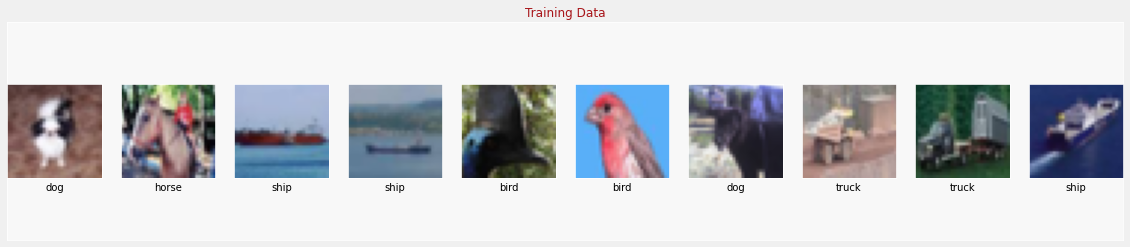

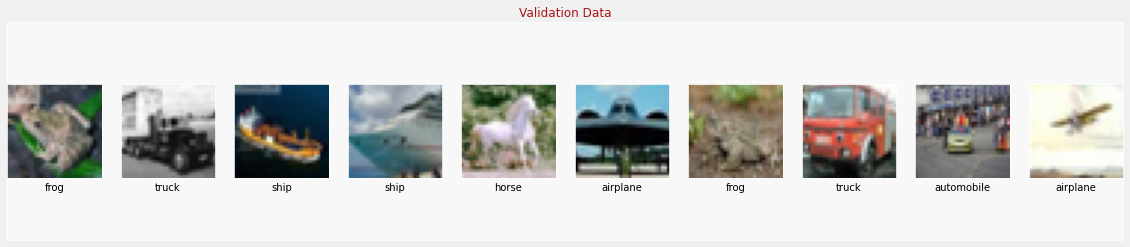

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data")

display_images(validation_images, validation_labels, validation_labels, "Validation Data")


In [6]:
def preprocess_image_input(input_images):
    input_images = input_images.astype("float32")
    output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_images

In [7]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [9]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.resnet.ResNet50(
        input_shape=(224,224,3),
        include_top=False,
        weights="imagenet"
    )(inputs)

    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def define_compile_mode():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)
    model.compile(
        optimizer="SGD",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model 

model = define_compile_mode()
model.summary()


94773248/94765736 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
______________________________________________________________

In [ ]:
EPOCHS = 4
hisotry = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data=(valid_X, validation_labels), batch_size=64)

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

In [ ]:
plot_metrics("loss","Loss")
plot_metrics("accuracy","Accuracy")


In [ ]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis=1)

display_images(validation_images, probabilities, validation_labels, "Bad prediction indicated in red.")



In [ ]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(
    image,
    boxes,
    color=[],
    thickness=1,
    display_str_list=()
):
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg,boxes,color,thickness,display_str_list)

    return np.array(rgbimg)

def draw_bounding_boxes_on_image(
    image,
    boxes,
    color=[],
    thickness=1,
    display_str_list=()
):
    boxes_shape = boxes.shape

    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError("input must be of size [N, 4]")

    for i in range(boxes_shape[0]):
        draw_bounding_boxes_on_image(
            image,
            boxes[i,1],
            boxes[i,0],
            boxes[i,3],
            boxes[i,2],
            color[i],
            thickness,
            display_str_list[i]
        )

def draw_bounding_box_on_image(
    image,
    ymin,
    xmin,
    ymax,
    xmax,
    color="red",
    thickness=1,
    display_str=None,
    use_normalized_coordinates=True
):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size

    if use_normalized_coordinates:
        (left,right,top,bottom)=(
            xmin+im_width, xmax+im_width,
            ymin+im_height,ymax+im_height
        )
    else:
        (left, right, top, bottom)=(
            xmin, xmax,
            ymin, ymax
        )
    
    draw.line([(left,top),(left,bottom),(right,bottom),(right,top),(left,top)], width=thickness, fill=color)

In [ ]:
plt.rc("image", cmap="gray")
plt.rc("grid", linewidth=0)
plt.rc("xtick", top=False, bottom=False, labelsize="large")
plt.rc("ytick", left=False, right=False, labelsize="large")
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')

MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
